# Jorge Andrés Villa Vélez - s1828592

# A database for a time-domain survey

In this excercise I will address the solutions for DBDM 2017 - Final Project excercise one "A database for a time-domain survey"

All the solutions were addressed using python and different useful packages to properly analyze and retrive information form the SQL queries. 

In each section, I describe the main important features and choices I made in order to properly achive the different goals of the project. 


In [1]:
'''Standard packages are loaded'''

import numpy as np
import os
import csv
import sqlite3 as lite
import pandas as pd
import seaborn as sns
from astropy.table import Table
from astropy.io import ascii
from astropy.io import fits
import matplotlib.pyplot as plt
# from matplotlib.ticker import NullFormatter
from sklearn.neighbors import KernelDensity
from sklearn.cluster import estimate_bandwidth
from sklearn.mixture import GaussianMixture

%matplotlib inline

In [2]:
'''Functions to read CSV files and FITS images are defined in this section'''

def read_CSV_file(fname):

    t = Table().read(fname)
    return t

def read_FITS_Catalogue(fname):

    if all:
        suff = '-all'
    else:
        suff = ''
       
    # ADJUST THIS LOCATION IF NECESSARY!!
    hdul = fits.open(fname)
    t = hdul[1].data
    hdul.close()

    return t

In [3]:
'''This was mainly used to check the dataset before using it'''

DATA_1 = read_FITS_Catalogue('Q1/Tables/FITS/Field-1-Ks-E001.fits')
DATA_2 = read_FITS_Catalogue('Q1/Tables/FITS/Field-1-Ks-E003.fits')
DATA_3 = read_FITS_Catalogue('Q1/Tables/FITS/Field-1-J.fits')
DATA_4 = read_FITS_Catalogue('Q1/Tables/FITS/Field-1-H.fits')

# print(DATA_1.shape)
# print(DATA_2.shape)
# print(DATA_1.columns)
# print(DATA_2.columns)
# print(DATA_1["StarID"])
# print(DATA_2["StarID"])
# print(DATA_3["StarID"])
#print(DATA_4["Mag1"][3862]) #There are nan values

In [4]:
'''To check the values and format to create Table1. (Observations)
Based on this, I am able to create Table2. (Stars) '''

Observations = read_CSV_file('Q1/Tables/file_info_for_problem.csv')

#Sorting to match information between files easily 
with open('Q1/Tables/file_info_for_problem.csv') as csvfile:
    spamreader   = csv.DictReader(csvfile, delimiter = ",")
    Observations_1 = sorted(spamreader, key = lambda x: (x["FieldID"], x["Filter"]))

#Sanity check
# print(int(Observations_1[4]["ID"]))   
# print(Observations_1[4])

In [5]:
'''Creating useful directories to organize data and properly create back-ups.
All fit files are backed up and then used to create CSV files to later
create the database. All the files are stored separately in convenient way.'''

os.system("mkdir Q1/Tables/CSV")
os.system("mkdir Q1/Tables/FITS")
os.system("mkdir Q1/Tables/DB")
os.system("cp Q1/Tables/FITS_COPY/*.fits Q1/Tables/FITS");
# os.system("mv Q1/Tables/*.fits Q1/Tables/FITS")

In [8]:
#I need to create the CSV files for every file 
#before creating the databases. 

My_List = os.listdir('Q1/Tables/FITS')
#Keeping the same order for files manipualtion
My_List = np.sort(My_List) 
# print(My_List)

My_List = os.listdir('Q1/Tables/FITS')
My_List = np.sort(My_List) #Sorting list to work them out by field
# print(My_List)

for i in range(len(My_List)):
    
    READ_FILE = Table.read('Q1/Tables/FITS/'+str(My_List[i]))
    READ_NAME = os.path.split(os.path.splitext('Q1/Tables/FITS/'+str(My_List[i]))[0])[1]

    ascii.write(READ_FILE, 'Q1/Tables/CSV/'+str(READ_NAME)+'.csv', format = 'csv',overwrite = True )
    
    print("Creating %s.csv \t\t Storing at Q1/Tables/CSV/"%(READ_NAME))  
    
#Sanity Check
# Check = read_CSV_file('Q1/Tables/CSV/Field-1-J.csv')
# Check

# X = Observations["Ra"][0:1000,]
# Y = Observations["Dec"][0:1000,]

# X = Observations["X"][0:1000,]
# Y = Observations["Y"][0:1000,]
# plt.scatter(X, Y)    

Creating Field-1-H.csv 		 Storing at Q1/Tables/CSV/
Creating Field-1-J.csv 		 Storing at Q1/Tables/CSV/
Creating Field-1-Ks-E001.csv 		 Storing at Q1/Tables/CSV/
Creating Field-1-Ks-E002.csv 		 Storing at Q1/Tables/CSV/
Creating Field-1-Ks-E003.csv 		 Storing at Q1/Tables/CSV/
Creating Field-1-Y.csv 		 Storing at Q1/Tables/CSV/
Creating Field-1-Z.csv 		 Storing at Q1/Tables/CSV/
Creating Field-2-H.csv 		 Storing at Q1/Tables/CSV/
Creating Field-2-J.csv 		 Storing at Q1/Tables/CSV/
Creating Field-2-Ks-E001.csv 		 Storing at Q1/Tables/CSV/
Creating Field-2-Y.csv 		 Storing at Q1/Tables/CSV/
Creating Field-2-Z.csv 		 Storing at Q1/Tables/CSV/
Creating Field-3-H.csv 		 Storing at Q1/Tables/CSV/
Creating Field-3-J.csv 		 Storing at Q1/Tables/CSV/
Creating Field-3-Ks-E001.csv 		 Storing at Q1/Tables/CSV/
Creating Field-3-Ks-E002.csv 		 Storing at Q1/Tables/CSV/
Creating Field-3-Y.csv 		 Storing at Q1/Tables/CSV/
Creating Field-3-Z.csv 		 Storing at Q1/Tables/CSV/


In [9]:
''' This is needed in order to add an extra column for every entry corresponding
to the FieldID, ID and Color Y-J and J-H. This info is taken from the filename 
and overwritten in the old CSV field to create the database'''

My_List_1 = os.listdir('Q1/Tables/CSV')
My_List_1 = np.sort(My_List_1)

H = []
J = []
Y = []

for j in range(len(My_List_1)):
    
    READ_NAME = os.path.split(os.path.splitext('Q1/Tables/FITS/'+str(My_List_1[j]))[0])[1]
    
    if READ_NAME[8] == 'H':
        H.append(My_List_1[j])
        
    if READ_NAME[8] == 'J':
        J.append(My_List_1[j])   
        
    if READ_NAME[8] == 'Y':
        Y.append(My_List_1[j])        

JH   = []  
YJ   = []
ID_1 = []

for k in range(len(H)):
    
    csv_input_1 = pd.read_csv('Q1/Tables/CSV/'+str(H[k]))
    csv_input_2 = pd.read_csv('Q1/Tables/CSV/'+str(J[k])) 
    csv_input_3 = pd.read_csv('Q1/Tables/CSV/'+str(Y[k]))
    
    for i in range(len(csv_input_1)):
        Color_1 = csv_input_2['Mag1'][i] - csv_input_1['Mag1'][i]
        Color_2 = csv_input_3['Mag1'][i] - csv_input_2['Mag1'][i]
        ID      = k + 1
        
        JH.append(Color_1)
        YJ.append(Color_2)
        ID_1.append(ID)
        
JH   = np.array(JH)
YJ   = np.array(YJ)
ID_1 = np.array(ID_1)

with open('Q1/Tables/Color_JH.csv', 'w') as f:
    writer = csv.writer(f, delimiter = ',')
    writer.writerow(['Color_JH', 'ID'])
    writer.writerows(zip(JH,ID_1))

with open('Q1/Tables/Color_YJ.csv', 'w') as f:
    writer = csv.writer(f, delimiter = ',')
    writer.writerow(['Color_YJ', 'ID'])
    writer.writerows(zip(YJ,ID_1))   
    
print("Color tables were created and stored at Q1/Tables/Color_JH.csv and Q1/Tables/Color_YJ.csv")    

Color tables were created and stored at Q1/Tables/Color_JH.csv and Q1/Tables/Color_YJ.csv


In [11]:
'''FieldID, ID and Colors J-h and Y-J are added to each file to 
addressed the queries in a better fashion'''

C_JH = pd.read_csv('Q1/Tables/Color_JH.csv')
C_YJ = pd.read_csv('Q1/Tables/Color_YJ.csv')

YJ_1 = np.array(C_YJ['Color_YJ'][:10000])
YJ_2 = np.array(C_YJ['Color_YJ'][10000:20000])
YJ_3 = np.array(C_YJ['Color_YJ'][20000:30000])

JH_1 = np.array(C_JH['Color_JH'][:10000])
JH_2 = np.array(C_JH['Color_JH'][10000:20000])
JH_3 = np.array(C_JH['Color_JH'][20000:30000])

for j in range(len(My_List_1)):
    
    READ_NAME = os.path.split(os.path.splitext('Q1/Tables/FITS/'+str(My_List_1[j]))[0])[1]
#     print(READ_NAME[6]) #It takes the field from the filename 
#     print(READ_NAME)
    csv_input = pd.read_csv('Q1/Tables/CSV/'+str(My_List_1[j]))
    
    csv_input['FieldID']  = READ_NAME[6]             #Adding extra column FieldID
    csv_input['ID']       = Observations_1[j]['ID']  #Adding extra column ID  
    
    if int(READ_NAME[6]) == 1:
        csv_input['YJ_Color'] = YJ_1
        csv_input['JH_Color'] = JH_1
        
    if int(READ_NAME[6]) == 2:
        csv_input['YJ_Color'] = YJ_2
        csv_input['JH_Color'] = JH_2
        
    if int(READ_NAME[6]) == 3:
        csv_input['YJ_Color'] = YJ_3 
        csv_input['JH_Color'] = JH_3
    
    csv_input.to_csv('Q1/Tables/CSV/'+str(My_List_1[j]), index = False)  
    
    print("Overwriting and Adding \
    FieldID,ID to %s.csv \t at Q1/Tables/CSV/ \t Size = %g"%(READ_NAME, len(csv_input)))

Overwriting and Adding     FieldID,ID to Field-1-H.csv 	 at Q1/Tables/CSV/ 	 Size = 10000
Overwriting and Adding     FieldID,ID to Field-1-J.csv 	 at Q1/Tables/CSV/ 	 Size = 10000
Overwriting and Adding     FieldID,ID to Field-1-Ks-E001.csv 	 at Q1/Tables/CSV/ 	 Size = 10000
Overwriting and Adding     FieldID,ID to Field-1-Ks-E002.csv 	 at Q1/Tables/CSV/ 	 Size = 10000
Overwriting and Adding     FieldID,ID to Field-1-Ks-E003.csv 	 at Q1/Tables/CSV/ 	 Size = 10000
Overwriting and Adding     FieldID,ID to Field-1-Y.csv 	 at Q1/Tables/CSV/ 	 Size = 10000
Overwriting and Adding     FieldID,ID to Field-1-Z.csv 	 at Q1/Tables/CSV/ 	 Size = 10000
Overwriting and Adding     FieldID,ID to Field-2-H.csv 	 at Q1/Tables/CSV/ 	 Size = 10000
Overwriting and Adding     FieldID,ID to Field-2-J.csv 	 at Q1/Tables/CSV/ 	 Size = 10000
Overwriting and Adding     FieldID,ID to Field-2-Ks-E001.csv 	 at Q1/Tables/CSV/ 	 Size = 10000
Overwriting and Adding     FieldID,ID to Field-2-Y.csv 	 at Q1/Tables/CSV/ 	

# a) Creation of a schema for the database

In this section, I will design a schema for my database in order to keep track of the location of the reduced data images, the catalogues detections in each image, and also the colors of stars and the variability in the Ks band. 

To make sure this scientific goals are achived properly, five different queries are performed later on the final created database. 

In [14]:
def load_data(filename = None):
    """Loads the data from a text file into an Astropy Table
    and returns the table. Throws if no file
    """
    if filename: return Table().read(filename,  format = 'csv')
    else: raise IOError("No input file given")

#Connection to the database.

def load_db(dbname = None, filename_2 = None):
    
    My_List_1 = os.listdir('Q1/Tables/CSV')
    
    #filename_1 = Stars
    #filename_1 = Observations
    """Loads the Stars and Observation tables into the appropriate database. 
    """
    con = lite.connect(dbname)
    
    with con:
    
        # Create the command to create the table. I use a 
        # multiline string to ease readability here.
        for j in range(len(My_List_1)):
            
            READ_NAME = os.path.split(os.path.splitext('Q1/Tables/FITS/'+str(My_List_1[j]))[0])[1]
            filename_1 = "Q1/Tables/CSV/"+str(My_List_1[j])
            
            table = 'Stars_%d'%j #I should put something here to create 3 different stars databases
            command = """CREATE TABLE IF NOT EXISTS Stars (RunningID DOUBLE, 
                                                X DOUBLE,
                                                Y DOUBLE,
                                                Flux1 DOUBLE,
                                                dFlux1 DOUBLE,
                                                Flux2 DOUBLE,
                                                dFlux2 DOUBLE,
                                                Flux3 DOUBLE,
                                                dFlux3 DOUBLE, 
                                                Ra DOUBLE,
                                                Dec DOUBLE,
                                                Class INT,
                                                Mag1 DOUBLE,
                                                dMag1 DOUBLE,
                                                Mag2 DOUBLE,
                                                dMag2 DOUBLE,
                                                Mag3 DOUBLE,
                                                dMag3 DOUBLE,
                                                StarID INT,
                                                FieldID INT,
                                                ID INT,
                                                YJ_Color DOUBLE,
                                                JH_Color DOUBLE)""".format(table)
        
        # Next, actually execute this command.
            con.execute(command)
    
        # Now that this is working, let us loop over the table entries
        # and insert these into the table.
            stars = load_data(filename_1)
            for row in stars:
                command = "INSERT INTO Stars VALUES('{0}','{1}','{2}','{3}','{4}',\
                '{5}','{6}','{7}','{8}','{9}','{10}','{11}','{12}',\
                '{13}','{14}','{15}','{16}','{17}','{18}', '{19}', '{20}', '{21}', '{22}')".format(row[0], \
                                                       row[1], row[2], row[3], row[4],\
                                                       row[5], row[6], row[7], row[8],\
                                                       row[9], row[10], row[11], row[12], row[13],\
                                                       row[14], row[15], row[16], row[17], row[18],\
                                                       row[19], row[20], row[21], row[22])
#             print(command)
                con.execute(command)
         
#         #
#         # Create the observations table.
#         #
        table = 'Observations'
        command = """CREATE TABLE IF NOT EXISTS Observations (ID INT,
                                                              FieldID INT,
                                                              Filename varchar(40),
                                                              Filter varchar(2),
                                                              MJD DOUBLE,
                                                              Airmass DOUBLE, 
                                                              Exptime DOUBLE,
                                                              UNIQUE(ID))""".format(table)        

    
        # Next, actually execute this command.
        con.execute(command)
    
        # Now that this is working, let us loop over the table entries
        # and insert these into the table.
        #
        # Note the '' around the string values - try to remove them, it won't go well!
        observations=load_data(filename_2)
        for row in observations:
            command = "INSERT INTO Observations VALUES('{0}','{1}','{2}','{3}','{4}','{5}','{6}')".format(row[0], \
                                                                                                row[1],\
                                                                                                row[2], row[3],\
                                                                                                row[4], row[5],\
                                                                                                row[6])
            print(command)
            con.execute(command)
            
# In case I want to re-create the databse with a different lay out            
os.system("rm -rf Q1/Tables/DB/*.db")

print("The database lay out is ready to be used")

The database lay out is ready to be used


In [15]:
'''The Stars table is already inside the lay out so the only relevant
table to be added is the Observations.'''

if __name__ == "__main__":
    load_db(dbname = "Q1/Tables/DB/DataBase.db", filename_2 = "Q1/Tables/file_info_for_problem.csv")

INSERT INTO Observations VALUES('1','1','Z-ADP.2017-01-18T11:58:36.905.fits','Z','57267.1671072','1.6405','40.0')
INSERT INTO Observations VALUES('2','1','J-ADP.2017-01-18T11:58:35.781.fits','J','57257.0504323','1.0105','48.0')
INSERT INTO Observations VALUES('3','1','H-ADP.2017-01-18T11:58:35.780.fits','H','57257.044108','1.006','16.0')
INSERT INTO Observations VALUES('4','1','Ks-ADP.2016-05-25T15:33:39.546.fits','Ks','56788.346937','1.023','16.0')
INSERT INTO Observations VALUES('5','1','Ks-ADP.2017-01-18T11:58:39.907.fits','Ks','56561.0020158','1.079','16.0')
INSERT INTO Observations VALUES('6','1','Ks-ADP.2016-05-25T15:33:43.377.fits','Ks','56829.0390512','1.6085','16.0')
INSERT INTO Observations VALUES('7','1','Y-ADP.2017-01-18T11:58:36.901.fits','Y','57267.1596647','1.5605','40.0')
INSERT INTO Observations VALUES('8','2','Z-ADP.2017-01-18T11:58:36.905b.fits','Z','57268.1671072','1.6405','40.0')
INSERT INTO Observations VALUES('9','2','J-ADP.2017-01-18T11:58:35.781b.fits','J','572

# b) SQL queries to answer R1, R2, R3, R4 and R5

__R1__ : *Find all the images observed between __MJD = 56800__ and __MJD  = 57300__ and give the number of stars detected with __S/N > 5__ in each image.*

__R2__ : *Find all the objects that have __J-H > 1.5__.*

__R3__ : *Find all the objects where __Ks__ differs by more than __20__ times the flux uncertainy from the mean flux.*

__R4__ : *Find all catalogues that exist for a given field*

__R5__ : *For a given field I would like to retrive the __Y__,__Z__,__J__,__H__ and __Ks__ magnitudes for all the stars with __S/N > 30__ in __Y__,__Z__,__J__,__H__ and __Ks__*

In [3]:
#Query R1

con = lite.connect('Q1/Tables/DB/DataBase.db')

Rows_1 = con.execute("""SELECT o.ID, o.FieldID, o.MJD, o.Filter, o.Filename, COUNT(s.StarID) \
FROM Stars as s LEFT JOIN Observations as o ON (o.ID = s.ID AND 1.0/s.dMag1 > 5 AND s.Class = -1) \
WHERE (o.MJD > 56800 AND o.MJD < 57300) \
GROUP BY o.filename ORDER BY o.ID""")

print("Number of stars with signal-to-noise > 5 and images with 56800 < MJD < 57300 \n")
for row in Rows_1:
    print("ID = %i   Field = %i \t Filter = %s \t Image name = %s    Stars in File = %i"%(row[0], row[1], row[3], row[4], row[5]))

Number of stars with signal-to-noise > 5 and images with 56800 < MJD < 57300 

ID = 1   Field = 1 	 Filter = Z 	 Image name = Z-ADP.2017-01-18T11:58:36.905.fits    Stars in File = 6447
ID = 2   Field = 1 	 Filter = J 	 Image name = J-ADP.2017-01-18T11:58:35.781.fits    Stars in File = 7021
ID = 3   Field = 1 	 Filter = H 	 Image name = H-ADP.2017-01-18T11:58:35.780.fits    Stars in File = 7982
ID = 6   Field = 1 	 Filter = Ks 	 Image name = Ks-ADP.2016-05-25T15:33:43.377.fits    Stars in File = 7888
ID = 7   Field = 1 	 Filter = Y 	 Image name = Y-ADP.2017-01-18T11:58:36.901.fits    Stars in File = 6790
ID = 8   Field = 2 	 Filter = Z 	 Image name = Z-ADP.2017-01-18T11:58:36.905b.fits    Stars in File = 6917
ID = 9   Field = 2 	 Filter = J 	 Image name = J-ADP.2017-01-18T11:58:35.781b.fits    Stars in File = 7354
ID = 10   Field = 2 	 Filter = H 	 Image name = H-ADP.2017-01-18T11:58:35.780b.fits    Stars in File = 7725
ID = 12   Field = 2 	 Filter = Y 	 Image name = Y-ADP.2017-01-18T11

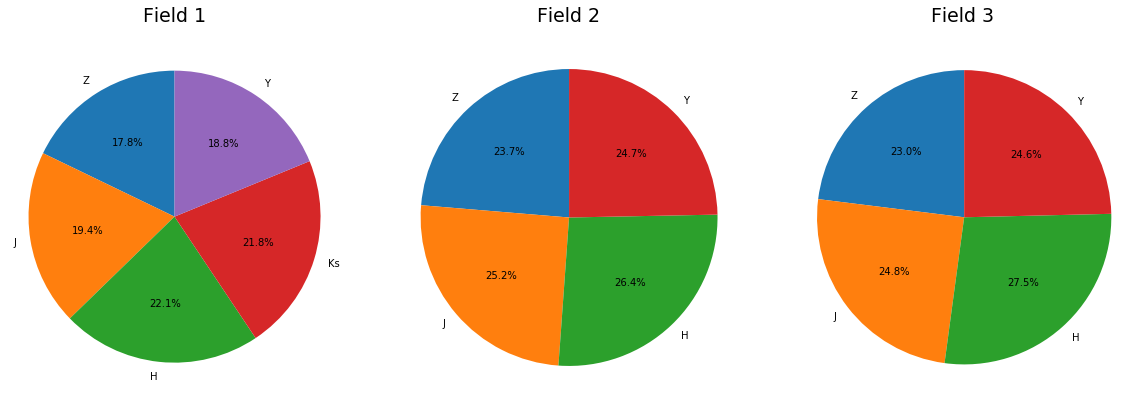

In [4]:
labels1 = ['Z','J','H','Ks', 'Y']
values1 = [6447, 7021, 7982, 7888, 6790]

labels2 = ['Z','J','H', 'Y']
values2 = [6917, 7354, 7725, 7212]

labels3 = ['Z','J','H', 'Y']
values3 = [6717, 7245, 8022, 7182]

fig, ((axA, axB, axC)) = plt.subplots(figsize = (20,7), ncols = 3, nrows = 1)

axA.pie(values1, labels = labels1, autopct = '%1.1f%%', startangle = 90)
axA.axis('equal')
axA.set_title('Field 1', size = 19)

axB.pie(values2, labels = labels2, autopct = '%1.1f%%', startangle = 90)
axB.axis('equal')
axB.set_title('Field 2', size = 19)

axC.pie(values3, labels = labels3, autopct = '%1.1f%%', startangle = 90)
axC.axis('equal')
axC.set_title('Field 3', size = 19)

plt.savefig("Query_1.png", dpi = 300)

In [5]:
#Query R2
#The way I constructed the database is easier to use python 

Color_JH = pd.read_csv('Q1/Tables/Color_JH.csv')
Color_YJ = pd.read_csv('Q1/Tables/Color_YJ.csv')

ColorJH = []
ColorYJ = []
Field   = []

for i in range(len(Color_JH)):
    if Color_JH['Color_JH'][i] > 1.5:
        ColorJH.append(Color_JH['Color_JH'][i])
        ColorYJ.append(Color_YJ['Color_YJ'][i])
        Field.append(Color_JH['ID'][i])  
        
print("The number of objects with color J-H > 1.5 is: %g"%len(ColorJH))        

The number of objects with color J-H > 1.5 is: 7154


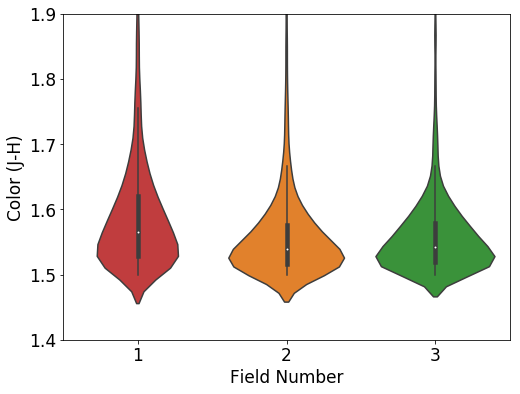

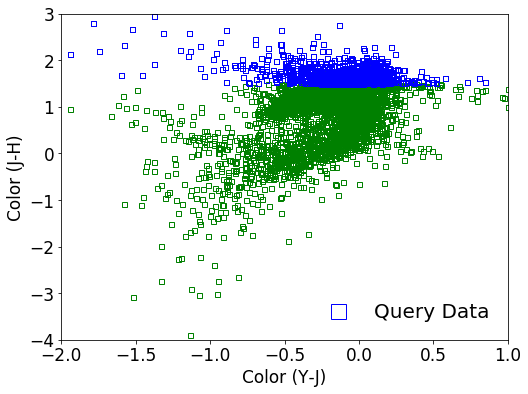

In [6]:
Color = ["C3", "C1", "C2"]

plt.figure(figsize = (8,6))
#sns.set_style(style = "ticks")
#sns.set_palette(palette = "hls")
ax = sns.violinplot(x = Field, y = ColorJH, palette = Color)
ax.set_ylabel('Color (J-H)', size = 17)
ax.set_xlabel('Field Number', size = 17)
ax.tick_params(axis = 'both', which = 'major', labelsize = 17)
ax.set_ylim(1.4, 1.9)
plt.savefig("Query_3_1.png", dpi = 300)


plt.figure(figsize = (8,6))
plt.plot(Color_YJ, Color_JH, '.', markerfacecolor = "None", markeredgecolor = 'green',marker = 's', ms = 5)
plt.plot(ColorYJ, ColorJH,  '.', markerfacecolor = "None", markeredgecolor = 'blue',marker = 's', ms = 5, label = 'Query Data')
plt.xlabel('Color (Y-J)', size = 17)
plt.ylabel('Color (J-H)', size = 17)
plt.xlim(-2,1)
plt.ylim(-4,3)
plt.tick_params(axis = 'both', which = 'major', labelsize = 17)
plt.legend(frameon = False, markerscale = 3, loc = 'best', prop = {'size': 20})
plt.savefig("Query_3_2.png", dpi = 300)

In [7]:
#Query R3

ROW_3_1 = """SELECT s.StarID FROM Stars as s LEFT JOIN Observations as o ON (o.ID == s.ID) \
WHERE o.Filter == 'Ks' AND o.FieldID == 1 AND \
ABS(s.Flux1 - (SELECT AVG(ss.Flux1) FROM Stars as ss LEFT JOIN Observations as oo \
WHERE (oo.Filter = 'Ks' AND ss.FieldID == oo.FieldID) GROUP BY ss.StarID) ) > ABS(20*s.dFlux1) GROUP BY s.StarID
"""

ROW_3_2 = """SELECT s.StarID FROM Stars as s LEFT JOIN Observations as o ON (o.ID == s.ID) \
WHERE o.Filter == 'Ks' AND o.FieldID == 2 AND \
ABS(s.Flux1 - (SELECT AVG(ss.Flux1) FROM Stars as ss LEFT JOIN Observations as oo \
WHERE (oo.Filter = 'Ks' AND ss.FieldID == oo.FieldID) GROUP BY ss.StarID) ) > ABS(20*s.dFlux1) GROUP BY s.StarID
"""

ROW_3_3 = """SELECT s.StarID FROM Stars as s LEFT JOIN Observations as o ON (o.ID == s.ID) \
WHERE o.Filter == 'Ks' AND o.FieldID == 3 AND \
ABS(s.Flux1 - (SELECT AVG(ss.Flux1) FROM Stars as ss LEFT JOIN Observations as oo \
WHERE (oo.Filter = 'Ks' AND ss.FieldID == oo.FieldID) GROUP BY ss.StarID) ) > ABS(20*s.dFlux1) GROUP BY s.StarID
"""

Field_1 = pd.read_sql_query(ROW_3_1, con)
Field_2 = pd.read_sql_query(ROW_3_2, con)
Field_3 = pd.read_sql_query(ROW_3_3, con)

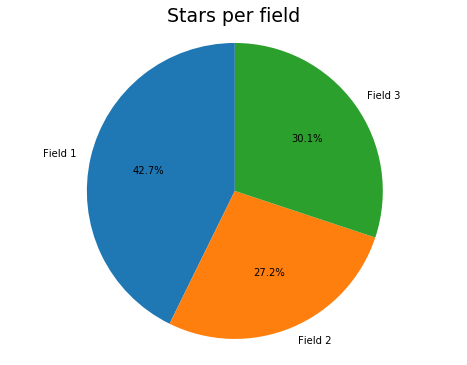

In [8]:
labels = ['Field 1','Field 2','Field 3']
values = [len(Field_1), len(Field_2), len(Field_3)]

plt.figure(figsize = (8,6))
plt.pie(values, labels = labels, autopct = '%1.1f%%', startangle = 90)
plt.axis('equal')
plt.title('Stars per field', size = 19)
plt.savefig("Stars.png", dpi = 300)

In [9]:
#Query R4

Rows_4 = con.execute("""SELECT NCat, Field FROM (SELECT o.FieldID as Field, \
o.ID, o.FieldID, COUNT(o.ID) as NCat \
FROM Observations as o GROUP BY o.FieldID)""")

for row in Rows_4:
    print("The number of Catalogs is: %i in Field %i"%(row[0], row[1]))

The number of Catalogs is: 7 in Field 1
The number of Catalogs is: 5 in Field 2
The number of Catalogs is: 6 in Field 3


In [10]:
#Query R5

Rows_5 = con.execute("""SELECT o.FieldID, o.Filter, COUNT(s.StarID) \
FROM Stars as s LEFT JOIN Observations as o ON (o.ID = s.ID AND 1.0/s.dMag1 > 30 AND s.Class = -1) \
WHERE (o.ID > 0) \
GROUP BY o.filename ORDER BY o.ID""")

for row in Rows_5:
    print("In Field %i and Filter %s there are %i stars"%(row[0], row[1], row[2]))    

In Field 1 and Filter Z there are 3501 stars
In Field 1 and Filter J there are 4636 stars
In Field 1 and Filter H there are 6185 stars
In Field 1 and Filter Ks there are 3948 stars
In Field 1 and Filter Ks there are 4421 stars
In Field 1 and Filter Ks there are 6421 stars
In Field 1 and Filter Y there are 3986 stars
In Field 2 and Filter Z there are 4432 stars
In Field 2 and Filter J there are 5150 stars
In Field 2 and Filter H there are 6048 stars
In Field 2 and Filter Ks there are 3959 stars
In Field 2 and Filter Y there are 4781 stars
In Field 3 and Filter Z there are 4071 stars
In Field 3 and Filter J there are 4918 stars
In Field 3 and Filter H there are 6148 stars
In Field 3 and Filter Ks there are 3899 stars
In Field 3 and Filter Ks there are 4702 stars
In Field 3 and Filter Y there are 4612 stars


In [11]:
#In order to use the Magnitude to make some plots

ROW_5 = """SELECT o.FieldID, o.Filter, s.Mag1 \
FROM Stars as s LEFT JOIN Observations as o ON (o.ID = s.ID AND 1.0/s.dMag1 > 30 AND s.Class = -1) \
WHERE (o.ID > 0) ORDER BY o.ID"""

Data = pd.read_sql_query(ROW_5, con)

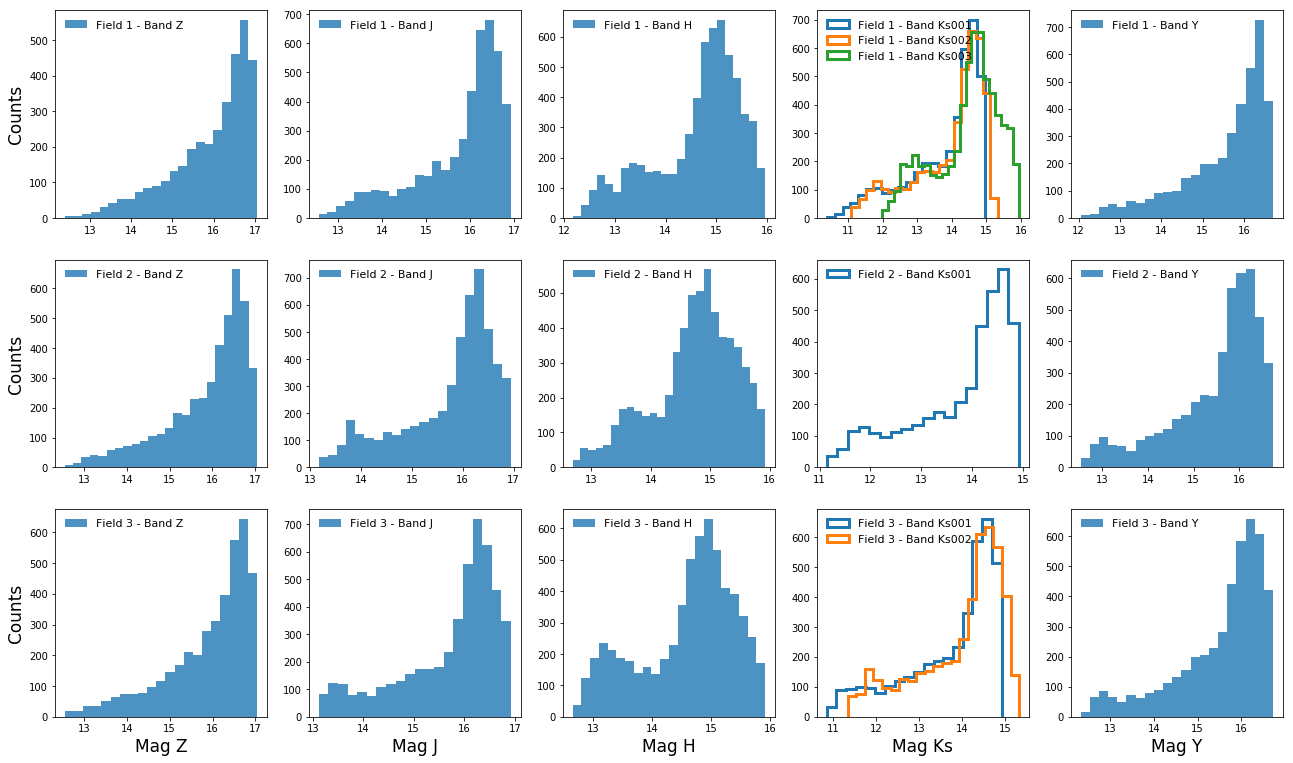

In [12]:
fig, ( (axA, axB, axC, axD, axE), (axF, axG, axH, axI, axJ), \
    (axK, axL, axM, axN, axO) ) = plt.subplots(figsize = (22,13), nrows = 3, ncols = 5)

axA.hist(Data['Mag1'][:3501], bins = 'scott', alpha = 0.8, label = 'Field 1 - Band Z');
axA.legend(frameon = False, markerscale = 7, loc = 'upper left', prop = {'size': 11})
axA.set_ylabel('Counts', size = 17)

axB.hist(Data['Mag1'][3501:8137], bins = 'scott', alpha = 0.8, label = 'Field 1 - Band J');
axB.legend(frameon = False, markerscale = 7, loc = 'upper left', prop = {'size': 11})

axC.hist(Data['Mag1'][8137:14322], bins = 'scott', alpha = 0.8, label = 'Field 1 - Band H');
axC.legend(frameon = False, markerscale = 7, loc = 'upper left', prop = {'size': 11})

axD.hist(Data['Mag1'][14322:18270], bins = 'scott', histtype = 'step', lw = 3, label = 'Field 1 - Band Ks001');
axD.hist(Data['Mag1'][18270:22691], bins = 'scott', histtype = 'step', lw = 3, label = 'Field 1 - Band Ks002');
axD.hist(Data['Mag1'][22691:29112], bins = 'scott', histtype = 'step', lw = 3, label = 'Field 1 - Band Ks003');
axD.legend(frameon = False, markerscale = 7, loc = 'upper left', prop = {'size': 11})

axE.hist(Data['Mag1'][29112:33098], bins = 'scott', alpha = 0.8, label = 'Field 1 - Band Y');
axE.legend(frameon = False, markerscale = 7, loc = 'upper left', prop = {'size': 11})

axF.hist(Data['Mag1'][33098:37530], bins = 'scott', alpha = 0.8, label = 'Field 2 - Band Z');
axF.legend(frameon = False, markerscale = 7, loc = 'upper left', prop = {'size': 11})
axF.set_ylabel('Counts', size = 17)

axG.hist(Data['Mag1'][37530:42680], bins = 'scott', alpha = 0.8, label = 'Field 2 - Band J');
axG.legend(frameon = False, markerscale = 7, loc = 'upper left', prop = {'size': 11})

axH.hist(Data['Mag1'][42680:48728], bins = 'scott', alpha = 0.8, label = 'Field 2 - Band H');
axH.legend(frameon = False, markerscale = 7, loc = 'upper left', prop = {'size': 11})

axI.hist(Data['Mag1'][48728:52687], bins = 'scott', histtype = 'step', lw = 3, label = 'Field 2 - Band Ks001');
axI.legend(frameon = False, markerscale = 7, loc = 'upper left', prop = {'size': 11})

axJ.hist(Data['Mag1'][52687:57468], bins = 'scott', alpha = 0.8, label = 'Field 2 - Band Y');
axJ.legend(frameon = False, markerscale = 7, loc = 'upper left', prop = {'size': 11})

axK.hist(Data['Mag1'][57468:61539], bins = 'scott', alpha = 0.8, label = 'Field 3 - Band Z');
axK.legend(frameon = False, markerscale = 7, loc = 'upper left', prop = {'size': 11})
axK.set_xlabel('Mag Z', size = 17)
axK.set_ylabel('Counts', size = 17)

axL.hist(Data['Mag1'][61539:66457], bins = 'scott', alpha = 0.8, label = 'Field 3 - Band J');
axL.legend(frameon = False, markerscale = 7, loc = 'upper left', prop = {'size': 11})
axL.set_xlabel('Mag J', size = 17)

axM.hist(Data['Mag1'][66457:72605], bins = 'scott', alpha = 0.8, label = 'Field 3 - Band H');
axM.legend(frameon = False, markerscale = 7, loc = 'upper left', prop = {'size': 11})
axM.set_xlabel('Mag H', size = 17)

axN.hist(Data['Mag1'][72605:76504], bins = 'scott', histtype = 'step', lw = 3, label = 'Field 3 - Band Ks001');
axN.hist(Data['Mag1'][76504:81206], bins = 'scott', histtype = 'step', lw = 3, label = 'Field 3 - Band Ks002');
axN.legend(frameon = False, markerscale = 7, loc = 'upper left', prop = {'size': 11})
axN.set_xlabel('Mag Ks', size = 17)

axO.hist(Data['Mag1'][81206:85818], bins = 'scott', alpha = 0.8, label = 'Field 3 - Band Y');
axO.legend(frameon = False, markerscale = 7, loc = 'upper left', prop = {'size': 11})
axO.set_xlabel('Mag Y', size = 17)

plt.savefig("Query_5.png", dpi = 300)

# c) Euclid mission new 100,000 stars sample from the last Y-J and J-H color distributions.

The Euclid mission will have thre filters __Y__, __J__ and __H__. In order to create a new sample of 100,000 stars to be used in a simulation we need to use the known distribution of our sample of stars in the __Y-J__, __J-H__ plane. 

In [4]:
'''I create a new file only with colors taking into account all those objects which
are classified as stars (i.e. Class = -1) in the three Y, J and H catalogues. Also
excluding some nan values to properly work with the data.'''

Model_JH = []
Model_YJ = []

for j in range(1,4):
    
    Field = pd.read_csv('Q1/Tables/CSV/Field-'+str(j)+'-J.csv')
    Field_1 = pd.read_csv('Q1/Tables/CSV/Field-'+str(j)+'-Y.csv')
    Field_2 = pd.read_csv('Q1/Tables/CSV/Field-'+str(j)+'-H.csv')

    for i in range(len(Field)):
        
        if Field["Class"][i] == -1 and Field_1["Class"][i] == -1 and Field_2["Class"][i] == -1:

            Model_JH.append(Field["JH_Color"][i])
            Model_YJ.append(Field["YJ_Color"][i])

Model_JH_new = [-1000 if np.isnan(x) else x for x in Model_JH]
Model_YJ_new = [-1000 if np.isnan(x) else x for x in Model_YJ]

Model_JH = []
Model_YJ = []   

for k in range(len(Model_JH_new)):
    if Model_JH_new[k] != -1000 and Model_JH_new[k] != -1000:
        Model_JH.append(Model_JH_new[k])
        Model_YJ.append(Model_YJ_new[k])  

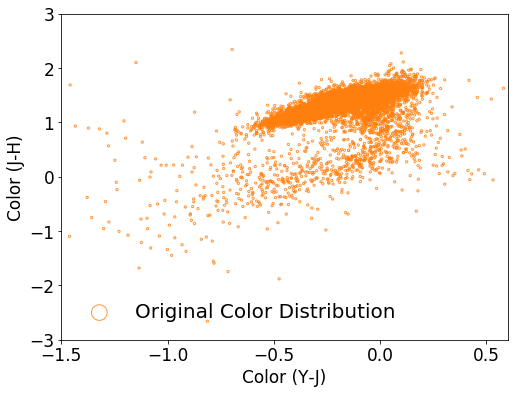

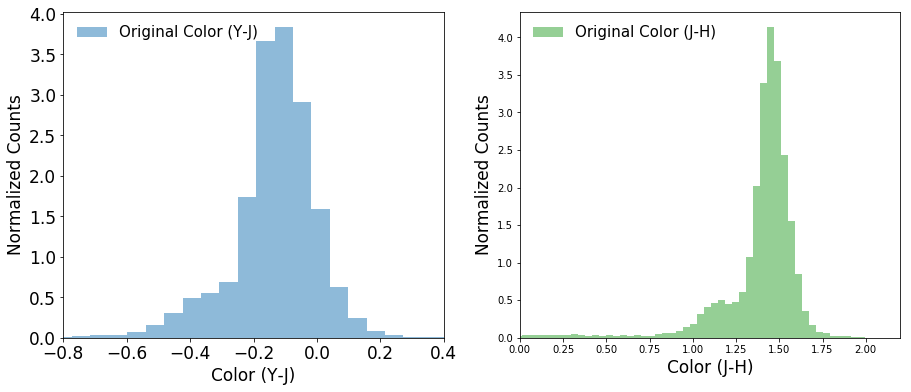

In [5]:
plt.figure(figsize = (8,6))
plt.scatter(Model_YJ, Model_JH, s = 5, facecolors = 'none', edgecolors = '#ff7f0e', alpha = 0.8, label = 'Original Color Distribution')
plt.xlim(-1.5, 0.6)
plt.ylim(-3, 3)
plt.xlabel('Color (Y-J)', size = 17)
plt.ylabel('Color (J-H)', size = 17)
plt.tick_params(axis = 'both', which = 'major', labelsize = 17)
plt.legend(frameon = False, markerscale = 7, loc = 'best', prop = {'size': 20})
plt.savefig('Euclid_OriginalDistribution.png', dpi = 300)

fig, ((axA, axB)) = plt.subplots(figsize = (15, 6), ncols = 2, nrows = 1)

axA.hist(Model_YJ, bins = 50, normed = True, color = '#1f77b4', alpha = 0.5, label = 'Original Color (Y-J)')
axA.set_xlim(-0.8, 0.4)
axA.tick_params(axis = 'both', which = 'major', labelsize = 17)
axA.legend(frameon = False, markerscale = 7, loc = 'upper left', prop = {'size': 15})
axA.set_xlabel('Color (Y-J)', size = 17)
axA.set_ylabel('Normalized Counts', size = 17)

axB.hist(Model_JH, bins = 'scott', normed = True, color = '#2ca02c', alpha = 0.5, label = 'Original Color (J-H)')
axB.set_xlim(0.0, 2.2)
axB.tick_params(axis = 50, which = 'major', labelsize = 17)
axB.legend(frameon = False, markerscale = 7, loc = 'upper left', prop = {'size': 15})
axB.set_xlabel('Color (J-H)', size = 17)
axB.set_ylabel('Normalized Counts', size = 17)

plt.savefig("Euclid_Hist_Original.png", dpi = 300)

In [27]:
# sns.set(style = "white",color_codes = True)

# xmin = np.nanmin(Model_YJ)
# xmax = np.nanmax(Model_YJ)
# ymin = np.nanmin(Model_JH)
# ymax = np.nanmax(Model_JH)

# data = np.column_stack((Model_YJ,Model_JH))
# df = pd.DataFrame(data, columns = ["YJ", "JH"])

# sns.jointplot(x = "YJ", y = "JH", data = df, kind = 'scatter', stat_func = None, \
#               color = 'g', size = 8, ratio = 3, space = 0.1, dropna = True, \
#               xlim = (-2,1), ylim = (-2,3));

In [187]:
#Using Kernel Density

X = np.column_stack((Model_YJ, Model_JH))

Bandwidth = estimate_bandwidth(X, quantile = 0.01, n_samples = None, random_state = 0, n_jobs = -1)
print("The best bandwidth to be used in the KDE is: %.3f"%(Bandwidth))
kde   = KernelDensity(Bandwidth, kernel = 'gaussian', metric = 'minkowski').fit(X)
Model = kde.sample(100000)

The best bandwidth to be used in the KDE is: 0.046


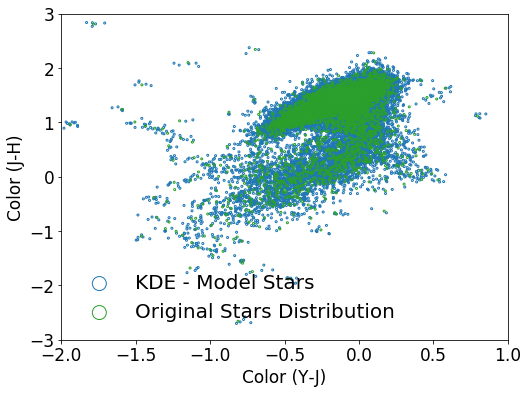

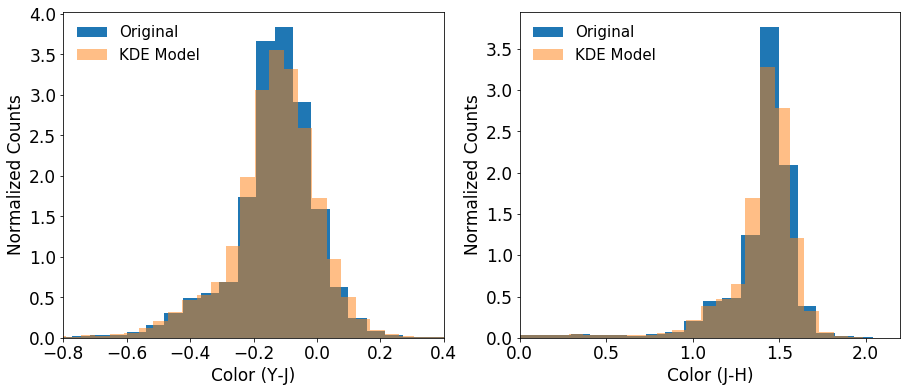

In [190]:
plt.figure(figsize = (8,6))
plt.scatter(Model[:,0], Model[:,1], s = 4, facecolors = 'none', edgecolors = '#1f77b4', label = 'KDE - Model Stars')
plt.scatter(Model_YJ, Model_JH, s = 4, edgecolors = '#2ca02c', facecolors = 'none', label = 'Original Stars Distribution')
plt.xlabel('Color (Y-J)', size = 17)
plt.ylabel('Color (J-H)', size = 17)
plt.xlim(-2,1)
plt.ylim(-3,3)
plt.tick_params(axis = 'both', which = 'major', labelsize = 17)
plt.legend(frameon = False, markerscale = 7, loc = 'best', prop = {'size': 20})
plt.savefig("Euclid_KDE_CMD.png", dpi = 300)

fig, ((axA, axB)) = plt.subplots(figsize = (15, 6), ncols = 2, nrows = 1)

axA.hist(Model_YJ, bins = 50, normed = True, label = 'Original');
axA.hist(Model[:,0], bins = 65, normed = True, alpha = 0.5, label = 'KDE Model');
axA.set_xlim(-0.8, 0.4)
axA.tick_params(axis = 'both', which = 'major', labelsize = 17)
axA.legend(frameon = False, markerscale = 7, loc = 'upper left', prop = {'size': 15})
axA.set_xlabel('Color (Y-J)', size = 17)
axA.set_ylabel('Normalized Counts', size = 17)

axB.hist(Model_JH, bins = 50, normed = True, label = 'Original');
axB.hist(Model[:,1], bins = 65, normed = True, alpha = 0.5, label = 'KDE Model');
axB.set_xlim(0.0, 2.2)
axB.tick_params(axis = 'both', which = 'major', labelsize = 17)
axB.legend(frameon = False, markerscale = 7, loc = 'upper left', prop = {'size': 15})
axB.set_xlabel('Color (J-H)', size = 17)
axB.set_ylabel('Normalized Counts', size = 17)
plt.savefig("Euclid_KDE_Histograms.png", dpi = 300)

In [157]:
N = range(1, 30)
models = [None for i in N]
for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)
    
# Compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

index_AIC = []
index_BIC = []

for i in range(len(AIC)):
    
    if np.abs(AIC[i]) == np.max(np.abs(AIC)):
        index_AIC.append(i)
        print("The minimum AIC is reached with %i Gaussians"%i)
        
    if np.abs(BIC[i]) == np.max(np.abs(BIC)):
        index_BIC.append(i)
        print("The minimum BIC is reached with %i Gaussians"%i)

The minimum BIC is reached with 5 Gaussians
The minimum AIC is reached with 15 Gaussians


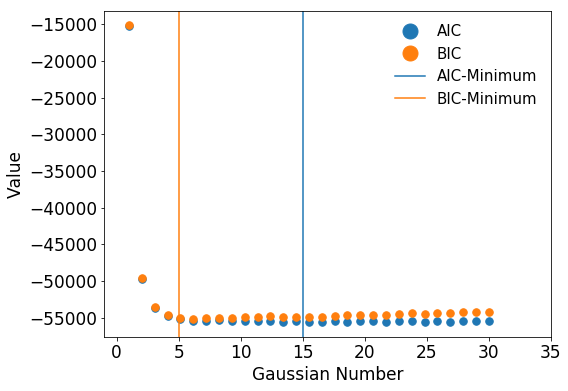

In [158]:
x = np.linspace(1,30,29)
plt.figure(figsize = (8,6))
plt.plot(x, AIC, '.', label = 'AIC', ms = 15)
plt.plot(x, BIC,'.', label = 'BIC', ms = 15)  
plt.axvline(index_AIC, c = '#1f77b4', label = 'AIC-Minimum')
plt.axvline(index_BIC, c = '#ff7f0e', label = 'BIC-Minimum')
plt.xlabel('Gaussian Number', size = 17)
plt.ylabel('Value', size = 17)
plt.tick_params(axis = 'both', which = 'major', labelsize = 17)
plt.legend(frameon = False, markerscale = 2, loc = 'best', prop = {'size': 15})
plt.xlim(-1,35)
plt.savefig("BIC_AIC_Criteria.png", dpi = 300)

In [182]:
model        = GaussianMixture(13)
Gaussian_Mix = model.fit(X)

Model = Gaussian_Mix.sample(100000)

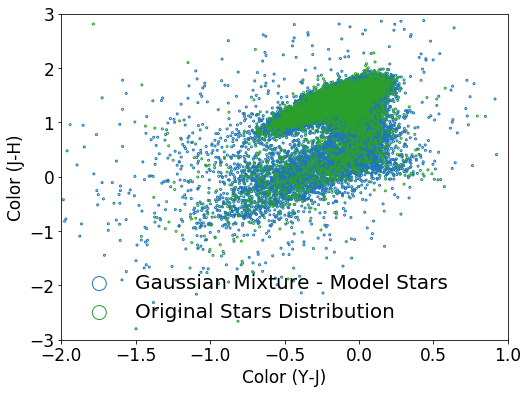

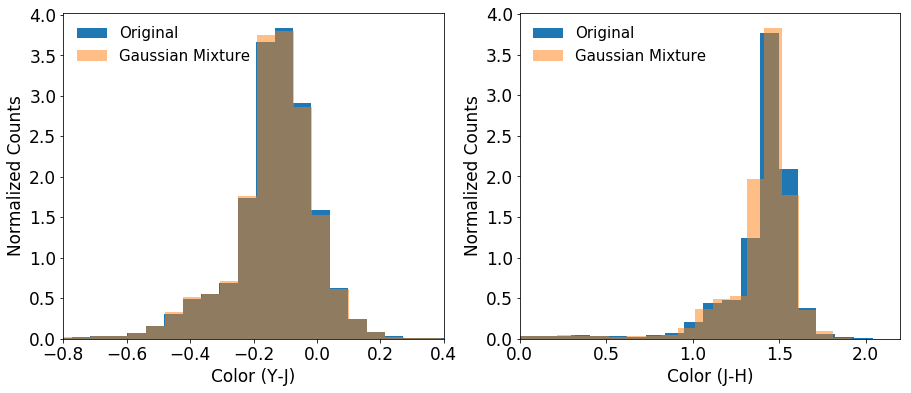

In [185]:
#Using Gaussian Mixture

plt.figure(figsize = (8,6))
plt.scatter(Model[0][:,0], Model[0][:,1], s = 4, facecolors = 'none', edgecolors = '#1f77b4', label = 'Gaussian Mixture - Model Stars' )
plt.scatter(Model_YJ, Model_JH, s = 4, edgecolors = '#2ca02c', facecolors = 'none', label = 'Original Stars Distribution')
plt.xlabel('Color (Y-J)', size = 17)
plt.ylabel('Color (J-H)', size = 17)
plt.xlim(-2,1)
plt.ylim(-3,3)
plt.tick_params(axis = 'both', which = 'major', labelsize = 17)
plt.legend(frameon = False, markerscale = 7, loc = 'best', prop = {'size': 20})
plt.savefig("Euclid_CMD_Gaussian.png", dpi = 300)

fig, ((axA, axB)) = plt.subplots(figsize = (15, 6), ncols = 2, nrows = 1)

axA.hist(Model_YJ, bins = 50, normed = True, label = 'Original');
axA.hist(Model[0][:,0], bins = 65, normed = True, alpha = 0.5, label = 'Gaussian Mixture');
axA.set_xlim(-0.8, 0.4)
axA.tick_params(axis = 'both', which = 'major', labelsize = 17)
axA.legend(frameon = False, markerscale = 7, loc = 'upper left', prop = {'size': 15})
axA.set_xlabel('Color (Y-J)', size = 17)
axA.set_ylabel('Normalized Counts', size = 17)

axB.hist(Model_JH, bins = 50, normed = True, label = 'Original');
axB.hist(Model[0][:,1], bins = 65, normed = True, alpha = 0.5, label = 'Gaussian Mixture');
axB.set_xlim(0.0, 2.2)
axB.tick_params(axis = 'both', which = 'major', labelsize = 17)
axB.legend(frameon = False, markerscale = 7, loc = 'upper left', prop = {'size': 15})
axB.set_xlabel('Color (J-H)', size = 17)
axB.set_ylabel('Normalized Counts', size = 17)

plt.savefig("Euclid_Gaussian.png", dpi = 300)

In [13]:
os.system("mv *.png Figures/")

0